## Setup

As always, we start with the usual imports and set a variant that supports automatic differentation.

In [13]:
import matplotlib.pyplot as plt 
import drjit as dr  
import mitsuba as mi
import miepython
import numpy as np
mi.set_variant('cuda_mono')

In [14]:
mi.variants()

['scalar_rgb',
 'scalar_spectral',
 'cuda_ad_rgb',
 'llvm_ad_rgb',
 'llvm_mono',
 'llvm_ad_mono',
 'cuda_ad_mono',
 'cuda_ad_spectral',
 'cuda_spectral',
 'cuda_mono',
 'llvm_ad_spectral',
 'llvm_spectral']

### Creating multiple sensors

We cannot hope to obtain a robust volumetric reconstruction using only a single reference image. Multiple viewpoints are needed to sufficiently constrain the reconstructed volume density.  Using a multi-view optimization we can recover volume parameters that generalize to novel views (and illumination conditions).

In this tutorial, we use 5 sensors placed on a half circle around the origin. For the simple optimization in this tutorial this is sufficient, but more complex scenes may require using significantly more views (e.g., using 50-100 sensors is not unreasonable).

In [15]:
from mitsuba import ScalarTransform4f as T

sensor_count = 5
sensors = []

for i in range(sensor_count):
    angle = 180.0 / sensor_count * i - 90.0
    sensor_rotation = T.rotate([0, 1, 0], angle)
    sensor_to_world = T.look_at(target=[0, 0, 0], origin=[4, 3 ,4], up=[0, 1, 0])
    #sensor_to_world = T.look_at(target=[0, 0, 0], origin=[0,2,0], up=[1, 1, 1])
    sensors.append(mi.load_dict({
        'type': 'perspective',
        'fov': 60,
        'to_world': sensor_rotation @ sensor_to_world,
        #'to_world': sensor_to_world,
        'film': {
            'type': 'hdrfilm',
            'width': 512, 'height': 512,
            'filter': {'type': 'tent'},
            'pixel_format':'luminance'
        }
    }))


In [52]:
def get_scene_dict(scale=1):
    scene_dict = {
        'type': 'scene',
        'integrator': {'type': 'prbvolpath'},
        'object': {
            'type': 'cube',
            'bsdf': {'type': 'null'},
            'to_world': T.scale(3),
            'interior': {
                'type': 'heterogeneous',
                'sigma_t': {
                    'type': 'gridvolume',
                    'filename': 'scenes/volume.vol',
                    'to_world': T.rotate([1, 0, 0], -90).scale(12).translate(-0.5)
                },
                'albedo': 0.99,
                'scale': 0
                
            }
        },
        'bunny':{
            'type': 'ply',
            'filename': 'scenes/meshes/bunny.ply',
            'to_world':T.translate(-0.25).translate([-0.5,-0.5,0.5]).scale(10),

            'bsdf':{'type':'diffuse' ,'reflectance': 0.9}
        },
        #use checkerboard as ground plane
        'rectangle_checkerboard':{
            'type': 'rectangle',
            'material': {
                'type': 'diffuse',
                'reflectance': {
                    'type': 'checkerboard',
                    'to_uv': T.scale(25)
                }
            
            },
            'to_world': T.rotate([1, 0, 0], -90).translate(-3.5).scale(100)

        },
        #place red sphere at (1,0,0)
        # 'red_sphere':{
        #     'type': 'sphere',
        #     'bsdf': {'type': 'diffuse', 'reflectance': {'type':'rgb','value': [1,0,0]}},
        #     'to_world': T.translate([2, 0, 0]).scale(0.3)
        # },
        # #place green sphere at (0,1,0)
        # 'green_sphere':{
        #     'type': 'sphere',
        #     'bsdf': {'type': 'diffuse', 'reflectance': {'type':'rgb','value': [0,1,0]}},
        #     'to_world': T.translate([0, 2, 0]).scale(0.3)
        # },
        # #place blue sphere at (0,0,1)
        # 'blue_sphere':{
        #     'type': 'sphere',
        #     'bsdf': {'type': 'diffuse', 'reflectance': {'type':'rgb','value': [0,0,1]}},
        #     'to_world': T.translate([0, 0, 2]).scale(0.3)
        # },
        # #place black sphere at (0,0,0)
        # 'black_sphere':{
        #     'type': 'sphere',
        #     'bsdf': {'type': 'diffuse', 'reflectance': {'type':'rgb','value': [0,0,0]}},
        #     'to_world': T.translate([0, 0, 0]).scale(0.3)
        # },
        #'emitter_light': {'type': 'constant','radiance': {'type': 'spectrum',"value": 0.9}},
        'emitter_light': {'type': 'envmap', 'filename': 'rnl_probe.exr','scale':1,'to_world': T.rotate([0, 1, 0], 180).scale(1)},
    }
    return scene_dict


In [53]:
scene_ref = mi.load_dict(get_scene_dict())

In [54]:
ref_images = []
for i in range(sensor_count):
    ref_images.append(mi.render(scene_ref, sensor=sensors[i], spp=32))
    
ref_image = mi.render(scene_ref, sensor=sensors[1], spp=32)

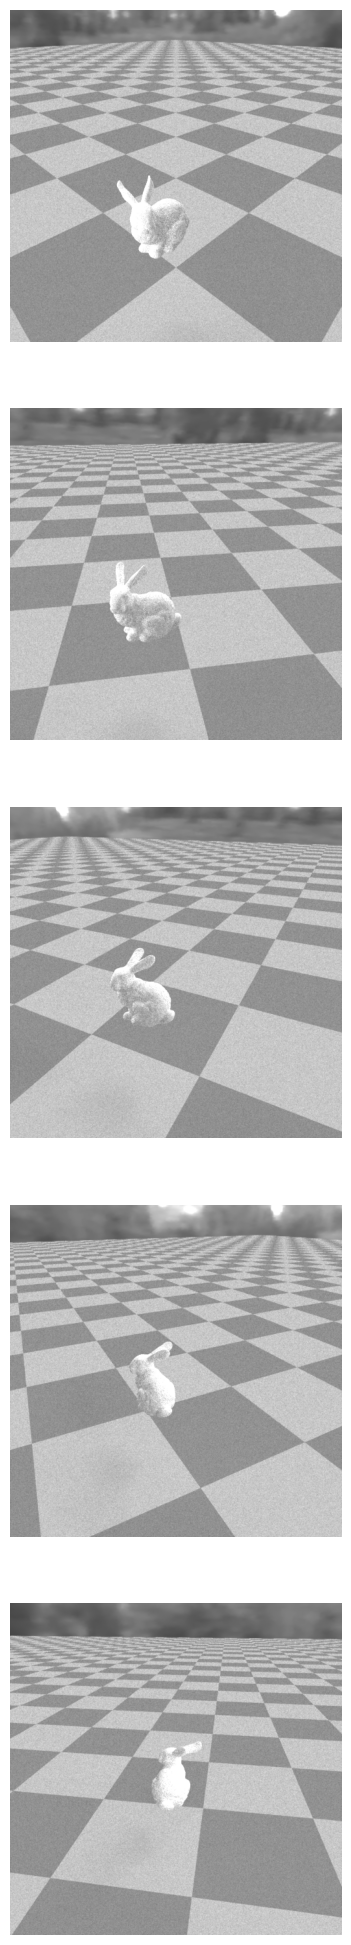

In [55]:
#Show all images in ref_images
fig, axs = plt.subplots(len(ref_images),1 ,figsize=(15, 5*len(ref_images)))
for i in range(len(ref_images)):
    axs[i].imshow(mi.util.convert_to_bitmap(ref_images[i]))
    #put title as the scaling factor used upto 2 decimal places
    #Make title smaller and figure bigger
    #axs[i].set_title(f"Scaling factor: {scaling_factor_smoke[i]:.2f}", fontsize=8)
    axs[i].axis('off')